<a href="https://colab.research.google.com/github/piotrjaniszewski1/SemEval-2020-Task12/blob/master/SemEval_2020_Task_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Package installation**

In [91]:
# Install necessary packages

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn

Requirement already up-to-date: symspellpy in /usr/local/lib/python3.6/dist-packages (6.5.2)
Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
     |████████████████████████████████| 174kB 2.9MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


# **Imports**

In [68]:
# All imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE

wordsegment.load()
spell = SpellChecker()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [69]:
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
print(training_dataset.head())

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]


# **Training and validation sets**

In [0]:
training_examples, validation_examples = train_test_split(training_dataset, test_size=0.1)

# prepare training examples
training_examples_A = training_examples['tweet'][training_examples['subtask_a'].notnull()]
training_examples_B = training_examples['tweet'][training_examples['subtask_b'].notnull()]
training_examples_C = training_examples['tweet'][training_examples['subtask_c'].notnull()]

# prepare validation examples
validation_examples_A = validation_examples['tweet'][validation_examples['subtask_a'].notnull()]
validation_examples_B = validation_examples['tweet'][validation_examples['subtask_b'].notnull()]
validation_examples_C = validation_examples['tweet'][validation_examples['subtask_c'].notnull()]

# prepare training labels
training_labels_A = (training_examples['subtask_a'][training_examples['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_examples['subtask_b'][training_examples['subtask_b'].notnull()] == 'TIN').astype(int)
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
training_labels_C = training_examples['subtask_c'][training_examples['subtask_c'].notnull()].replace(c_mapping)

# prepare validation labels
validation_labels_A = (validation_examples['subtask_a'][validation_examples['subtask_a'].notnull()] == 'OFF').astype(int)
validation_labels_B = (validation_examples['subtask_b'][validation_examples['subtask_b'].notnull()] == 'TIN').astype(int)
validation_labels_C = (validation_examples['subtask_c'][validation_examples['subtask_c'].notnull()]).replace(c_mapping)


training_x = list(training_examples_A)
validation_x = list(validation_examples_A)
training_y = list(training_labels_A)
validation_y = list(validation_labels_A)

# **Preprocessing**

In [84]:
# normalization -> papers, complicated solutions

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


# all preprocessing executions
def preprocess_basic(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    text = text.lower()

    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        if flag == True:
            suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
            if len(suggestions) > 0:
                edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text


cleaned_x = [preprocess_basic(example) for example in training_x[0:30]]
print(cleaned_x[0:30])
print(training_x[0:30])

[['@user', '@user', '@user', '@user', 'amazing', 'organizer', 'clap', 'hand', 'medium', 'dark', 'skin', 'tone'], ['mind', 'open', 'conservative', 'republican', 'maga', 'shadow', 'ban', 'america', 'trump', 'patriot', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'walk', 'away', 'walk', 'away', 'democrat', 'fake', 'news', '@user', '@user', '@user', '@user', '@user', '@user', 'url'], ['@user', 'disgusting', 'proof', 'property', 'home', 'ownership', 'myth', 'not', 'pay', 'taxis', 'rent', 'throw', 'land', 'need', 'permission', 'build', 'land'], ['@user', 'enemy', 'great', 'point', 'compromise', 'source', 'method', 'source', 'method', 'conservative', 'concerned', 'drain', 'swamp'], ['@user', 'loudly', 'cry', 'face', 'loudly', 'cry', 'face', 'loudly', 'cry', 'face', 'loudly', 'cry', 'face', 'terrible', 'ok', 'button'], ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'thank', 'allow', 'aboard', 'proudly', 'follow', '

In [0]:
# Remove redundant @user tokens
def remove_redundant_users(example):
  user_count = 0
  new_example = example[:]
  for i, token in reversed(list(enumerate(example))):
    if token == '@user':
      user_count += 1
      if user_count > 3:
        new_example.pop(i)

    else:
      user_count = 0

  return new_example

reduced_users_x = [remove_redundant_users(example) for example in cleaned_x]

# **Class imbalance**

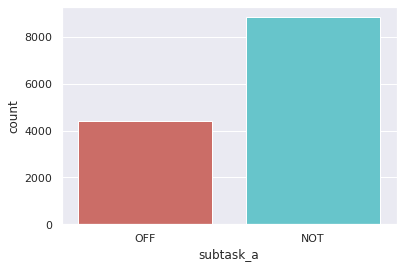

subtask_a
NOT    8840
OFF    4400
Name: id, dtype: int64


In [90]:
#Depict class imbalance for the subtask A
sns.set(font_scale=1.0)
countplt=sns.countplot(x='subtask_a', data=training_dataset, palette ='hls')
plt.show()

print(training_dataset.groupby('subtask_a').count()['id'])

In [0]:
# [1] SMOTE + ADA-SYN + Tomek links -> use preferably exclusive with [2]



In [0]:
# [2] Levelling instances importance -> use peferably exclusive with [1]

